In [1]:
import numpy as np
import os
import yaml
from skimage import exposure
from tqdm import tqdm

import matplotlib.pyplot as plt
import pickle


In [2]:
data_dir = "keren"
with open("keren/meta.yaml", "r") as f:
    metadata = yaml.safe_load(f)

cell_types_meta = metadata['cell_types']
channel_names = metadata['channels']

non_biologic_markers = ['AR', 'Au', 'C', 'P']
channel_names = [name for name in channel_names if name not in non_biologic_markers]


In [3]:
def normalize(X):
    for i in tqdm(range(X.shape[-1])):
        X[..., i] = exposure.rescale_intensity(X[..., i], out_range=(-1, 1))
        X[..., i] = exposure.equalize_adapthist(X[..., i])
    return X

In [4]:
import cv2

# Define the size of the crop
crop_size = 64

def bounding_box(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols):
        # Return the entire image if mask is empty
        return 0, 0, mask.shape[1], mask.shape[0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return xmin, ymin, xmax, ymax

def crop_cells(image, mask, num=2000):
    cells = []
    labels = []
    cells_selection = np.random.choice(np.arange(0, np.max(mask)), size=num, replace=False)
    cell_to_type = {}
    # Iterate through each cell in the mask
    for i in tqdm(cells_selection):
        # Extract the bounding box of the cell
        y, x = np.where(mask == i)
        if len(y) == 0 or len(x) == 0:
            continue
        x1, y1, x2, y2 = x.min(), y.min(), x.max(), y.max()
        
        # Crop the cell image and mask
        cell_image = image[y1:y2, x1:x2]
        
        # Resize the cell image and mask to the crop size
        cell_image = cv2.resize(cell_image, (crop_size, crop_size))
        
        # Add the cell and label to the dataset
        cell_type = cell_types[i]
        cells.append(cell_image)
        labels.append(cell_type)
        cell_to_type[i] = cell_type
    
    return cells, labels, cell_to_type

In [5]:
# Process images/crop/etc. 
# Change count or remove count to do all the files
# Change num=2000 to num=len(X[0]) to do all cells within the file
count = 0
cells = []
labels = []
cell_types = []
for image_file in os.listdir(data_dir):
    if ".npz" in image_file:
        data = np.load(os.path.join(data_dir, image_file), allow_pickle=True)
        cell_types = data['cell_types'].item()
        y = data['y']
        X = data['X']
        X = normalize(X)
        cells_curr, labels_curr, cell_to_type = crop_cells(X[0], y[0, ..., -1], num=2000)
        cells.extend(cells_curr)
        labels.extend(labels_curr)
    count += 1
    if count >= 2:
        break

100%|██████████| 2000/2000 [00:29<00:00, 67.61it/s]


In [6]:
cells = np.array(cells)
labels = np.array(labels)
expression_panel = np.zeros((len(cell_types_meta), len(channel_names)))
for i in tqdm(range(cells.shape[0])):
    cell_type = labels[i]
    
    for j, channel_name in enumerate(channel_names):
        channel_index = metadata['channels'].index(channel_name)
        expression_panel[cell_type, j] += cells[i, ..., channel_index].mean()

# Average the marker expression panel over all cell instances
expression_panel /= cells.shape[0]

100%|██████████| 2000/2000 [00:01<00:00, 1036.40it/s]


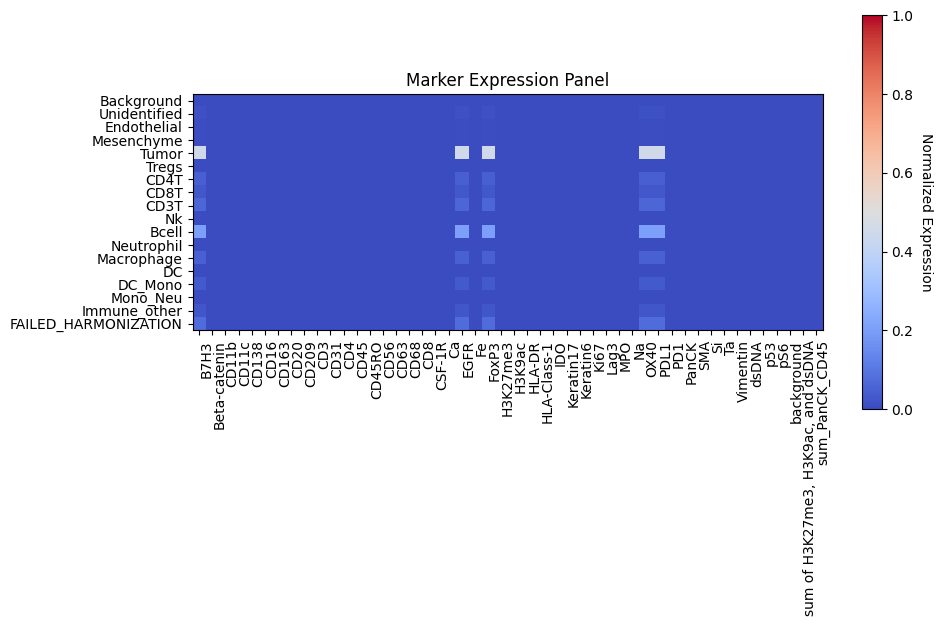

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming expression_panel is a numpy array containing the marker expression values
# with shape (num_cell_types, num_markers)
# cell_type_names is a list of strings containing the names of the cell types
# marker_names is a list of strings containing the names of the markers

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(expression_panel, cmap='coolwarm', vmin=0, vmax=1)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Normalized Expression', rotation=-90, va="bottom")

# Set tick labels
ax.set_xticks(np.arange(len(channel_names)))
ax.set_yticks(np.arange(len(cell_types_meta)))
ax.set_xticklabels(channel_names)
ax.set_yticklabels(cell_types_meta.values())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")


ax.set_title("Marker Expression Panel")
fig.tight_layout()
plt.show()

In [8]:
with open("cell_imgs.pkl", "wb") as f:
    pickle.dump(cells, f)


In [9]:
with open("cell_labels.pkl", "wb") as f:
    pickle.dump(labels, f)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [11]:
class CellDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(51, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 18)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.reshape(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in tqdm(train_loader):
            inputs = inputs.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                inputs = inputs.permute(0, 3, 1, 2)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, train_acc*100, val_loss, val_acc*100))

# Training

In [12]:
# Load data
X = cells
y = labels

# Define dataset and data loaders
dataset = CellDataset(X, y)
train_set, val_set = torch.utils.data.random_split(dataset, [1600, 400])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

# Define model, loss function, and optimizer
model = CNNModel()
model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), 'model.pt')

100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


Epoch [1/10], Train Loss: 1.9031, Train Acc: 42.94%, Val Loss: 1.9937, Val Acc: 46.25%


100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Epoch [2/10], Train Loss: 1.8210, Train Acc: 42.81%, Val Loss: 1.9294, Val Acc: 46.50%


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch [3/10], Train Loss: 1.8059, Train Acc: 44.94%, Val Loss: 1.8263, Val Acc: 46.25%


100%|██████████| 13/13 [00:02<00:00,  6.28it/s]


Epoch [4/10], Train Loss: 1.8004, Train Acc: 44.88%, Val Loss: 1.9895, Val Acc: 46.00%


 66%|██████▌   | 33/50 [00:13<00:07,  2.39it/s]


KeyboardInterrupt: 

# Eval

In [ ]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, data_loader):
    model.eval()
    model.double()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.permute(0, 3, 1, 2)  # Assuming your inputs need the same permutation as before
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

In [ ]:
def experiment(X, y):
    dataset = CellDataset(X, y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Loading from weights
    model = CNNModel()
    state_dict = torch.load('model.pt')
    model.load_state_dict(state_dict)
    model.double()

    predictions, true_labels = get_predictions(model, val_loader)  # Replace val_loader with test_loader if needed

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(cm)
    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(cell_types_meta)))
    ax.set_yticks(np.arange(len(cell_types_meta)))
    ax.set_xticklabels(cell_types_meta.values())
    ax.set_yticklabels(cell_types_meta.values())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
            rotation_mode="anchor")
    plt.show()

    return predictions, true_labels
    

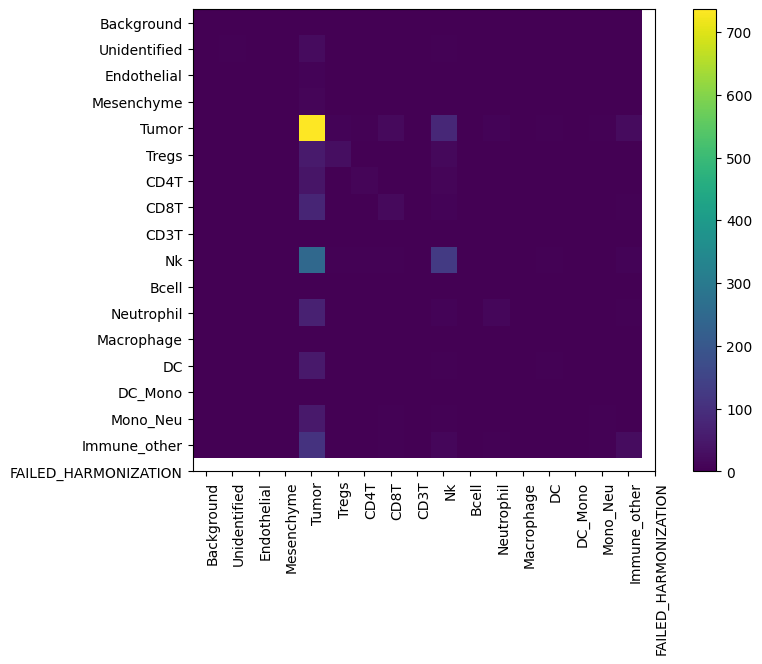

In [ ]:
# Given X = cropped images and y = labels, plots confusion matrix and gives predictions/truths
preds, truths = experiment(X, y)